In [7]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
torch.cuda.set_device(0)  # For GPU 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


1
NVIDIA GeForce GTX 1650
Using device: cuda


In [8]:
pip install torch torchaudio matplotlib pandas scikit-learn tqdm librosa

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\DHRUV\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [51]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import librosa
from collections import Counter

# Set the path to your dataset and CSV file
DATA_PATH = r"D:\MLgunshot\UrbanSound8k"
CSV_PATH = r"D:\MLgunshot\UrbanSound8K Images\UrbanSound8k.csv"

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [56]:
# Function to create mel spectrogram
def create_mel_spectrogram(audio_path, n_mels=128, n_fft=2048, hop_length=512):
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.mean(dim=0)  # Convert stereo to mono if necessary
    
    # Resample if the sample rate is not 44100 Hz
    if sample_rate != 44100:
        resampler = torchaudio.transforms.Resample(sample_rate, 44100)
        waveform = resampler(waveform)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=44100,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )(waveform)
    
    mel_spectrogram = librosa.power_to_db(mel_spectrogram.numpy(), ref=np.max)
    return torch.tensor(mel_spectrogram)

In [57]:
class UrbanSoundDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        audio_path = os.path.join(DATA_PATH, f"fold{row['fold']}", row['slice_file_name'])
        mel_spec = create_mel_spectrogram(audio_path)
        
        # Add a channel dimension (C=1) to the mel spectrogram
        mel_spec = mel_spec.unsqueeze(0)  # Shape: [1, n_mels, time_steps]
        
        if self.transform:
            mel_spec = self.transform(mel_spec)
        return mel_spec, row['classID']

In [58]:
# Load and preprocess data
df = pd.read_csv(CSV_PATH)

# Calculate length of each audio clip and remove short clips
MIN_LEN = 0.30
df['length'] = df['end'] - df['start']
df_clean = df[df['length'] >= MIN_LEN]
print(f'{df.shape[0] - df_clean.shape[0]} instances removed')

67 instances removed


In [59]:
#Split the data
train_df, test_df = train_test_split(df_clean, test_size=0.2, stratify=df_clean['classID'], random_state=42)

# CNN Model
class UrbanSoundCNN(nn.Module):
    def __init__(self, num_classes):
        super(UrbanSoundCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [60]:
# Prepare datasets and dataloaders
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[-40.2709], std=[14.3644])  # Adjust these values based on your data
])

train_dataset = UrbanSoundDataset(train_df, transform=transform)
test_dataset = UrbanSoundDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
# Initialize the model, loss function, and optimizer
num_classes = df_clean['classID'].nunique()
model = UrbanSoundCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [61]:
# Print data information
print(f"Total number of samples: {len(df_clean)}")
print(f"Number of classes: {num_classes}")
print("Class distribution:")
print(df_clean['classID'].value_counts().sort_index())

Total number of samples: 8665
Number of classes: 10
Class distribution:
classID
0    1000
1     389
2    1000
3     984
4    1000
5    1000
6     365
7    1000
8     927
9    1000
Name: count, dtype: int64


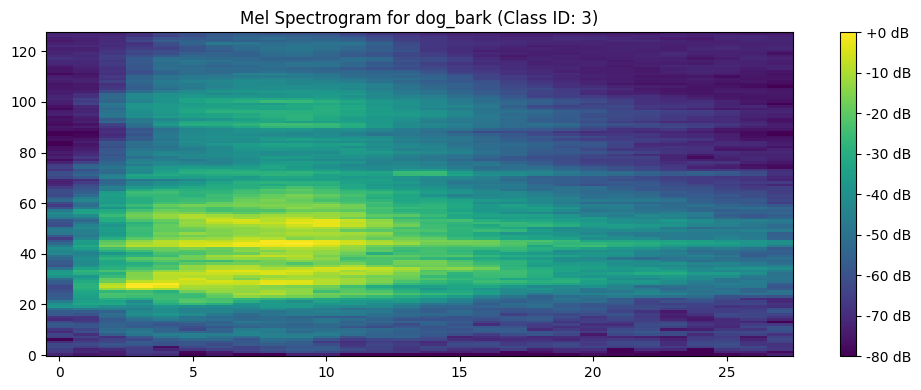

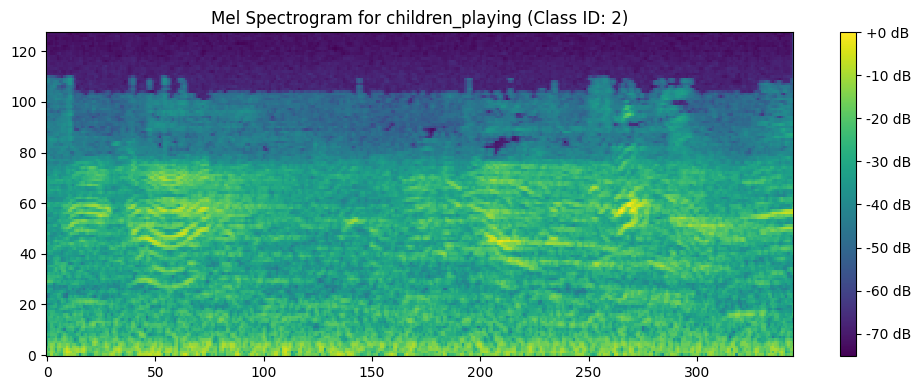

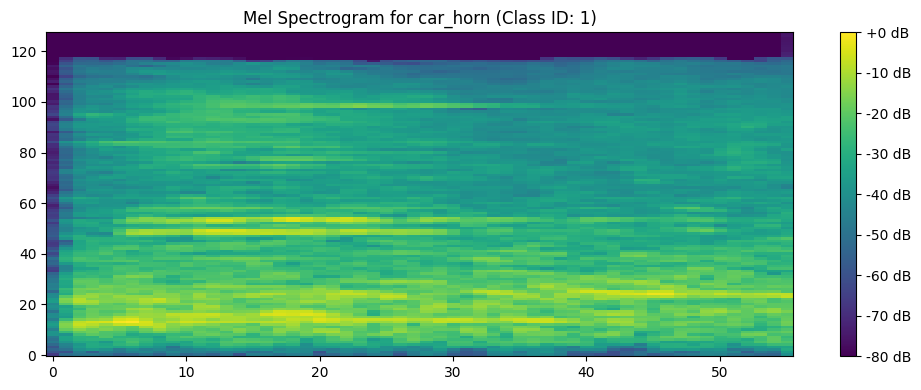

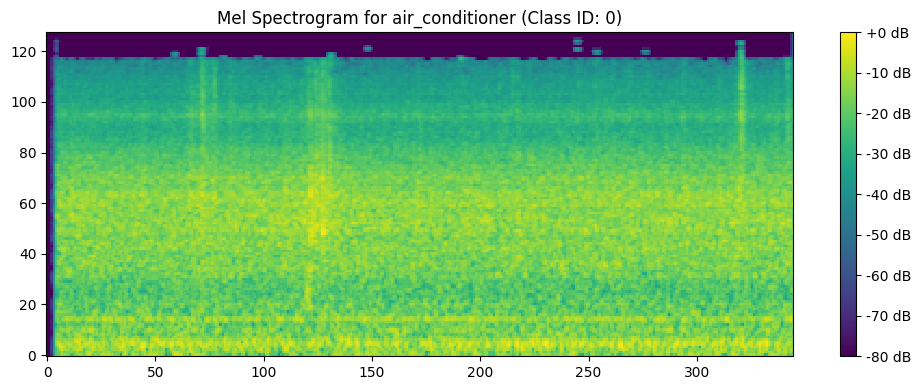

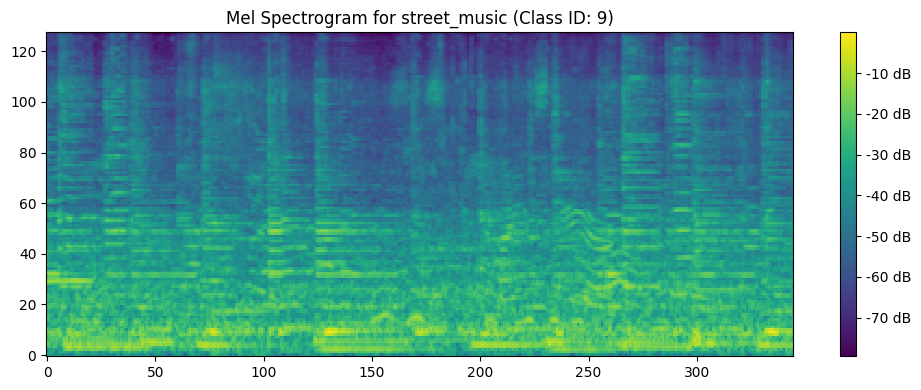

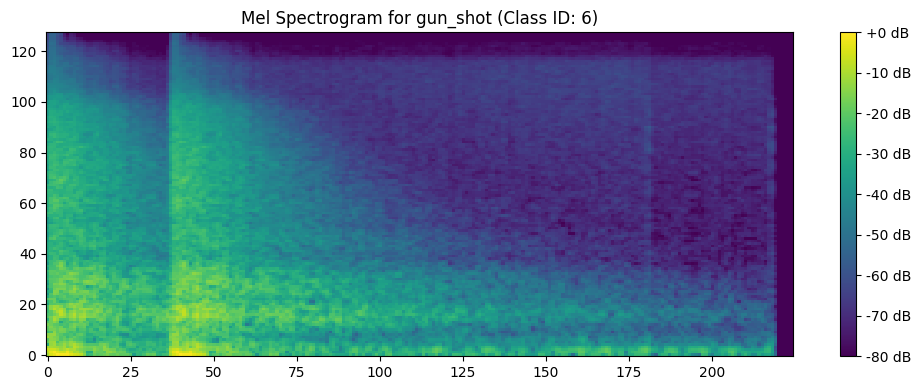

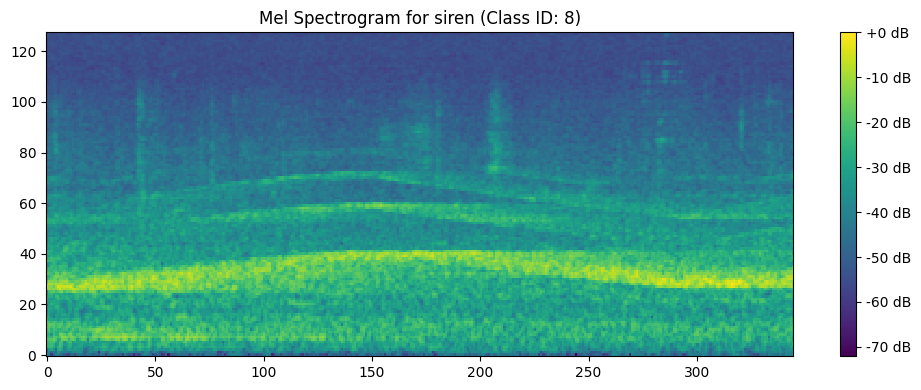

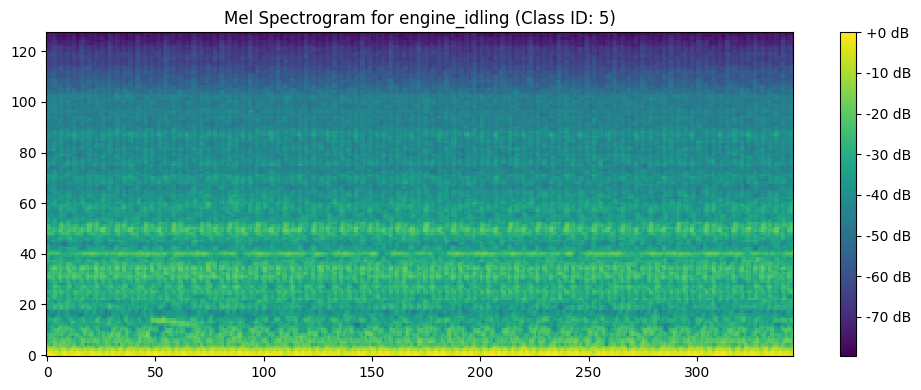

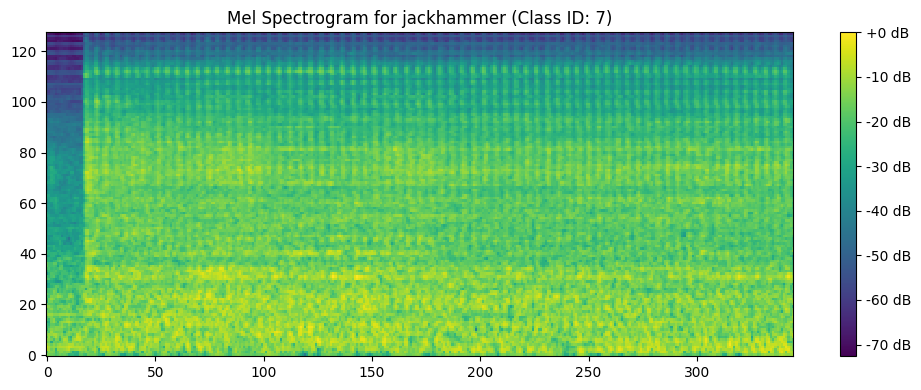

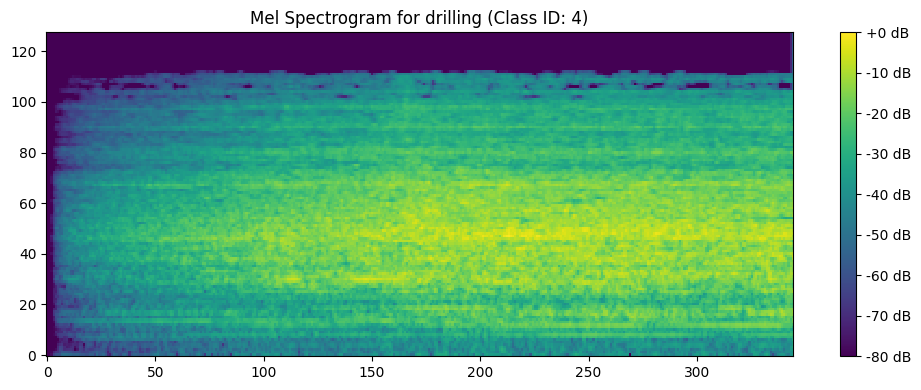

Batch 1:
Input shape: torch.Size([32, 1, 128, 128])
Labels shape: torch.Size([32])
Labels: tensor([2, 7, 4, 3, 7, 7, 7, 3, 0, 9, 9, 5, 8, 8, 8, 4, 7, 0, 3, 4, 0, 2, 9, 0,
        5, 4, 7, 1, 6, 4, 4, 5])


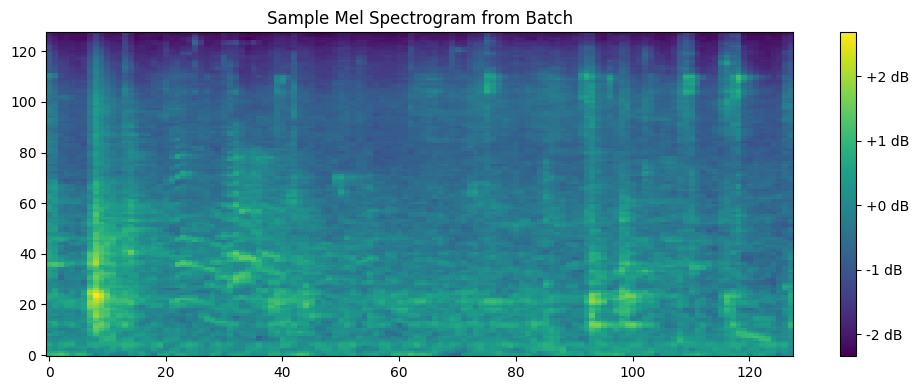

Data preparation and mel spectrogram generation verified successfully!


In [62]:
import matplotlib.pyplot as plt

def plot_mel_spectrogram(mel_spec, title):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.squeeze().numpy(), aspect='auto', origin='lower', interpolation='nearest')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Get unique class IDs and their names
class_ids = df_clean['classID'].unique()
class_names = df_clean['class'].unique()

# Generate and plot a mel spectrogram for a sample from each class
for class_id, class_name in zip(class_ids, class_names):
    sample = df_clean[df_clean['classID'] == class_id].iloc[0]
    audio_path = os.path.join(DATA_PATH, f"fold{sample['fold']}", sample['slice_file_name'])
    mel_spec = create_mel_spectrogram(audio_path)
    plot_mel_spectrogram(mel_spec, f"Mel Spectrogram for {class_name} (Class ID: {class_id})")

# Verify data loader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels}")
    
    # Plot the first mel spectrogram in the batch
    plot_mel_spectrogram(inputs[0], "Sample Mel Spectrogram from Batch")
    
    if batch_idx == 0:  # Only check the first batch
        break

print("Data preparation and mel spectrogram generation verified successfully!")

Batch 1:
Input shape: torch.Size([32, 1, 128, 128])
Labels shape: torch.Size([32])
Labels: tensor([0, 5, 2, 2, 7, 0, 3, 3, 0, 4, 5, 1, 5, 8, 0, 3, 8, 7, 8, 0, 7, 1, 4, 2,
        9, 1, 2, 3, 7, 9, 3, 6])


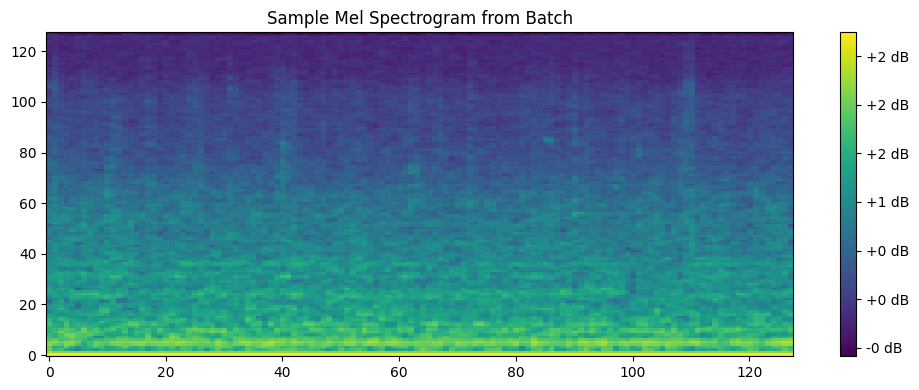

Batchwise Data preparation and mel spectrogram generation verified successfully!


In [63]:
# Verify data loader
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels}")
    
    # Plot the first mel spectrogram in the batch
    plot_mel_spectrogram(inputs[0], "Sample Mel Spectrogram from Batch")
    
    if batch_idx == 0:  # Only check the first batch
        break

print("Batchwise Data preparation and mel spectrogram generation verified successfully!")

In [64]:
def balance_data(df, target_count=700):
    balanced_data = []
    class_counts = Counter(df['classID'])
    
    for class_id, count in class_counts.items():
        class_data = df[df['classID'] == class_id]
        
        if count < target_count:
            class_data = class_data.sample(n=target_count, replace=True)
        elif count > target_count:
            class_data = class_data.sample(n=target_count, replace=False)
        
        balanced_data.append(class_data)
    
    return pd.concat(balanced_data, ignore_index=True)

df_balanced = balance_data(df_clean)
print(f"Balanced dataset shape: {df_balanced.shape}")

Balanced dataset shape: (7000, 9)


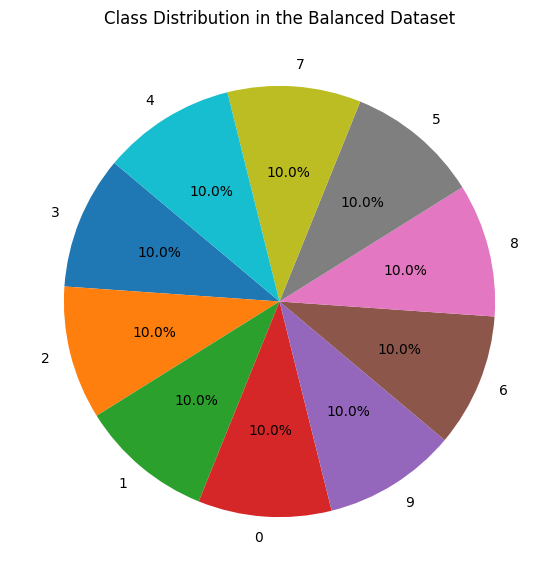

Total number of samples: 7000
Number of classes: 10
Class distribution:
classID
0    700
1    700
2    700
3    700
4    700
5    700
6    700
7    700
8    700
9    700
Name: count, dtype: int64


In [67]:
import matplotlib.pyplot as plt

# Count the number of samples per class in the balanced dataset
class_counts = df_balanced['classID'].value_counts()

# Plot pie chart
plt.figure(figsize=(10, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution in the Balanced Dataset')
plt.show()
# Print data information
print(f"Total number of samples: {len(df_balanced)}")
print(f"Number of classes: {num_classes}")
print("Class distribution:")
print(df_balanced['classID'].value_counts().sort_index())

Epoch 50/50: 100%|██████████| 217/217 [01:06<00:00,  3.24it/s, loss=0.00122, accuracy=99.9] 


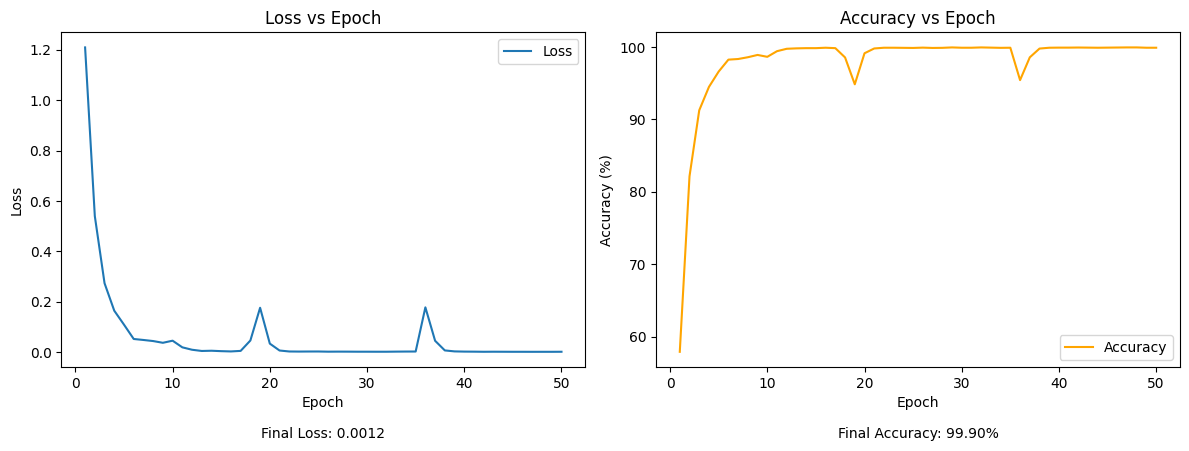

Evaluating: 100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


Test Accuracy: 91.06%
Model saved as 'gunshot_indentifier2.pth'


In [68]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize lists to store loss and accuracy values
losses = []
accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({'loss': running_loss/len(train_loader), 'accuracy': 100.*correct/total})
    
    # Store loss and accuracy for this epoch
    losses.append(running_loss / len(train_loader))
    accuracies.append(100. * correct / total)

# Plot Loss vs Accuracy
plt.figure(figsize=(12, 8))  # Increased figure height to accommodate labels

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

# Add final loss label
plt.text(0.5, -0.2, f'Final Loss: {losses[-1]:.4f}', 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes)

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()

# Add final accuracy label
plt.text(0.5, -0.2, f'Final Accuracy: {accuracies[-1]:.2f}%', 
         horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100.*correct/total:.2f}%')

In [91]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {100.*correct/total:.2f}%')


Evaluating: 100%|██████████| 55/55 [00:39<00:00,  1.38it/s]


Test Accuracy: 91.06%
Model saved as 'gunshot_indentifier.pth'


In [97]:
# Save the entire model
torch.save(model, 'D:/MLgunshot/guns.pth')
print("Model saved as 'gunshot_indentifier2.pth'")
model.eval()

Model saved as 'gunshot_indentifier2.pth'


UrbanSoundCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)

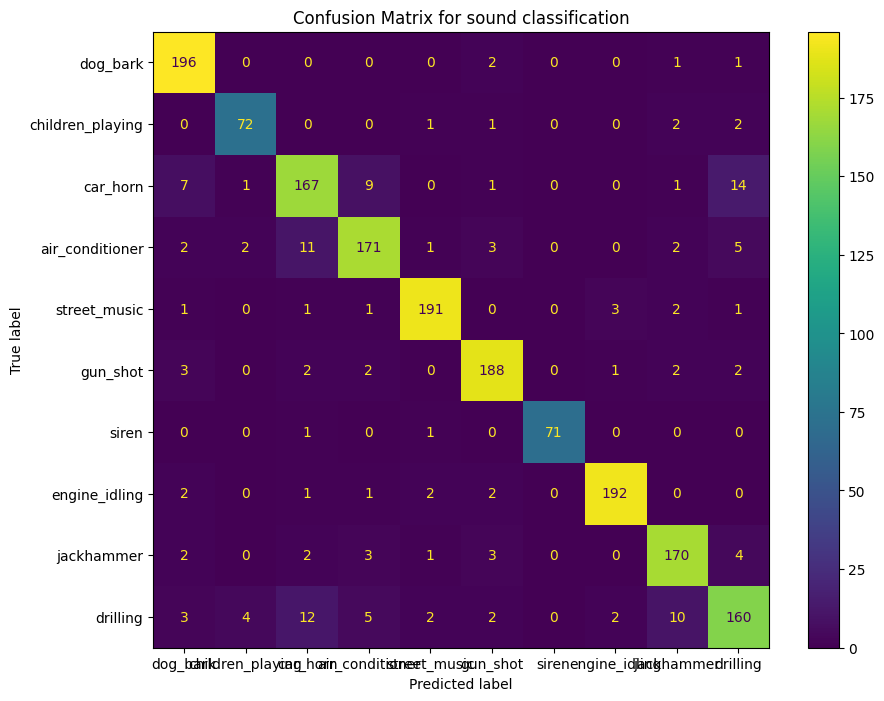

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Function to compute confusion matrix
def compute_confusion_matrix(loader, model, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    return confusion_matrix(all_labels, all_preds)

# Compute confusion matrix
cm = compute_confusion_matrix(test_loader, model, device)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='viridis', colorbar=True)
plt.title('Confusion Matrix for sound classification')
plt.show()


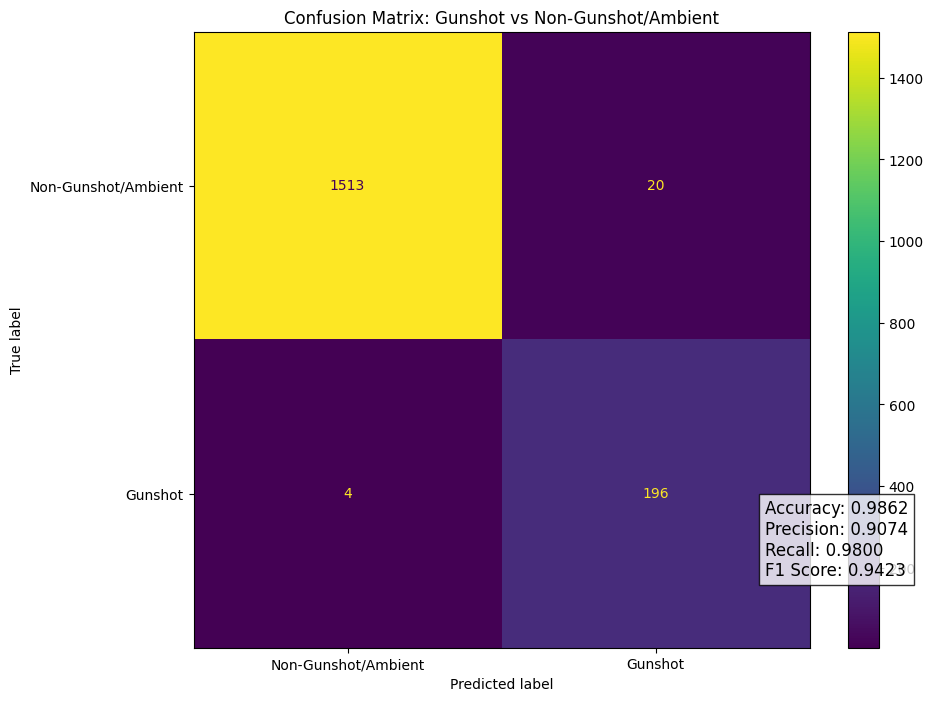

In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def create_binary_confusion_matrix(y_true, y_pred, gunshot_class_id):
    # Create a binary version of y_true and y_pred
    y_true_binary = (y_true == gunshot_class_id).astype(int)
    y_pred_binary = (y_pred == gunshot_class_id).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    return cm

def plot_binary_confusion_matrix_with_metrics(cm, accuracy, precision, recall, f1_score):
    class_names = ['Non-Gunshot/Ambient', 'Gunshot']
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='viridis', values_format='d')
    plt.title('Confusion Matrix: Gunshot vs Non-Gunshot/Ambient')

    # Add metrics as text on the plot
    metrics_text = (f"Accuracy: {accuracy:.4f}\n"
                    f"Precision: {precision:.4f}\n"
                    f"Recall: {recall:.4f}\n"
                    f"F1 Score: {f1_score:.4f}")
    
    # Positioning the text on the plot
    plt.gcf().text(0.7, 0.2, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()

# Assuming you have your test set and predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Assuming the gunshot class has ID 0 (adjust this if it's different in your dataset)
gunshot_class_id = 0

# Create the binary confusion matrix
cm_binary = create_binary_confusion_matrix(y_true, y_pred, gunshot_class_id)

# Calculate metrics
tn, fp, fn, tp = cm_binary.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) != 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

# Plot the confusion matrix with the metrics included
plot_binary_confusion_matrix_with_metrics(cm_binary, accuracy, precision, recall, f1_score)


Class IDs and Names:
Class ID: 0, Class Name: air_conditioner
Class ID: 1, Class Name: car_horn
Class ID: 2, Class Name: children_playing
Class ID: 3, Class Name: dog_bark
Class ID: 4, Class Name: drilling
Class ID: 5, Class Name: engine_idling
Class ID: 6, Class Name: gun_shot
Class ID: 7, Class Name: jackhammer
Class ID: 8, Class Name: siren
Class ID: 9, Class Name: street_music

The predicted class for the audio file is: gun_shot (Class ID: 6)


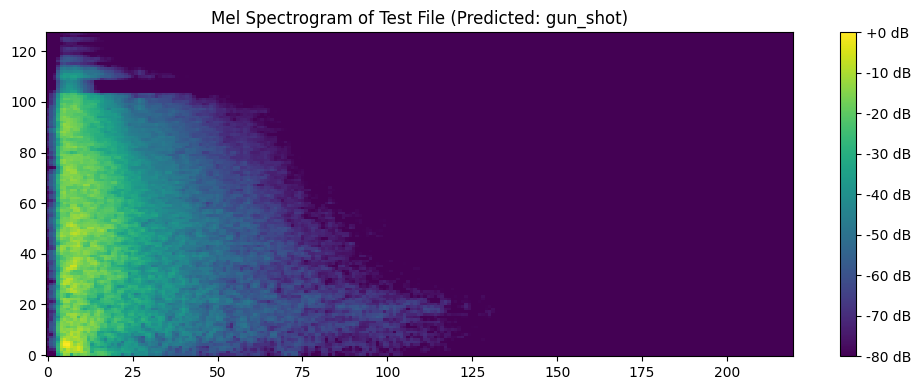

In [99]:
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms

# Load the trained model
model.eval()

# Function to predict the class of an audio file
def predict_audio_file(file_path, model, device):
    # Create mel spectrogram
    mel_spec = create_mel_spectrogram(file_path)
    
    # Add batch and channel dimensions
    mel_spec = mel_spec.unsqueeze(0).unsqueeze(0)
    
    # Apply the same transform as used in training
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.Normalize(mean=[-40.2709], std=[14.3644])
    ])
    mel_spec = transform(mel_spec)
    
    # Move to the appropriate device
    mel_spec = mel_spec.to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(mel_spec)
        _, predicted = torch.max(output, 1)
    
    return predicted.item()

# Path to your test audio file
test_file_path = r"D:\MLgunshot\audioTEST\pistol.wav"

# Ensure the file extension is included
if not test_file_path.endswith('.wav'):
    test_file_path += '.wav'

# Predict the class of the test file
predicted_class = predict_audio_file(test_file_path, model, device)

# Ensure class names match
class_names = df_clean[['classID', 'class']].drop_duplicates().sort_values(by='classID')
class_names_dict = class_names.set_index('classID')['class'].to_dict()

# Print all class names with IDs
print("Class IDs and Names:")
for class_id, class_name in class_names_dict.items():
    print(f"Class ID: {class_id}, Class Name: {class_name}")

# Get the predicted class name
predicted_class_name = class_names_dict.get(predicted_class, "Unknown")

print(f"\nThe predicted class for the audio file is: {predicted_class_name} (Class ID: {predicted_class})")

# Optional: Plot the mel spectrogram of the test file
test_mel_spec = create_mel_spectrogram(test_file_path)
plot_mel_spectrogram(test_mel_spec, f"Mel Spectrogram of Test File (Predicted: {predicted_class_name})")
